### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

### Load Pretrained Model

In [2]:
# Load a pretrained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Utility Function to Get Model Features and Gradients

In [3]:
from typing import Tuple

def get_features_gradients(model: nn.Module, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Forward pass to get the features and register hook to get gradients.

    Parameters:
    - model (nn.Module): Neural network model
    - x (torch.Tensor): Input image tensor

    Returns:
    - features (torch.Tensor): Extracted features from the last convolutional layer
    - gradients (torch.Tensor): Gradients w.r.t the features
    """
    features = None
    gradients = None

    def hook_feature(module, input, output):
        nonlocal features
        features = output.detach()

    def hook_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    handle_forward = model.features[-1].register_forward_hook(hook_feature)
    handle_backward = model.features[-1].register_backward_hook(hook_gradient)

    # Forward and backward pass
    model.zero_grad()
    output = model(x)
    # Class-specific backprop
    output.backward(torch.Tensor([[1 if idx == 243 else 0 for idx in range(output.shape[1])]]))

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    return features, gradients

### Generate Grad-CAM Heatmap

In [4]:
from typing import Tuple

def generate_grad_cam(features: torch.Tensor, gradients: torch.Tensor, image_shape: Tuple[int, int]) -> torch.Tensor:
    """
    Generate Grad-CAM heatmap.

    Parameters:
    - features (torch.Tensor): Extracted features from the last convolutional layer
    - gradients (torch.Tensor): Gradients w.r.t the features
    - image_shape (Tuple[int, int]): Original shape of the input image (height, width)

    Returns:
    - torch.Tensor: Grad-CAM heatmap
    """
    # Global average pooling on gradients to get neuron importance
    alpha = gradients.mean(dim=[2, 3], keepdim=True)

    # Weighted sum of feature maps based on neuron importance
    weighted_features = features * alpha

    # ReLU applied on weighted combination of feature maps
    heatmap = nn.functional.relu(weighted_features.sum(dim=1, keepdim=True))

    # Resizing the heatmap to original image size
    heatmap = nn.functional.interpolate(heatmap, size=image_shape, mode='bilinear', align_corners=False)

    return heatmap

### Function to Overlay Heatmap on Original Image

In [5]:
import cv2
import matplotlib.pyplot as plt
from typing import Union
import numpy as np

def overlay_heatmap_on_image(image: Union[np.ndarray, Image.Image],
                             heatmap: Union[np.ndarray, torch.Tensor],
                             alpha: float = 0.5) -> np.ndarray:
    """
    Overlay the Grad-CAM heatmap on the original image.

    Parameters:
    - image (np.ndarray or PIL.Image): Original input image
    - heatmap (Union[np.ndarray, torch.Tensor]): Grad-CAM heatmap
    - alpha (float): Weight of the heatmap when overlaying

    Returns:
    - np.ndarray: Image with heatmap overlaid
    """
    # Convert PIL image to numpy array if necessary
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convert torch.Tensor to numpy array if necessary
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.numpy()

    # Normalize the heatmap and convert to RGB format
    heatmap_normalized = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap_colored, (image.shape[1], image.shape[0]))

    # Overlay heatmap on image
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_resized, alpha, 0)

    return overlayed

### Function to Visualize Heatmap

In [6]:
from typing import Union
import numpy as np
import matplotlib.pyplot as plt

def visualize_heatmap(image: Union[np.ndarray, Image.Image],
                      heatmap: torch.Tensor,
                      figsize: Tuple[int, int] = (12, 6)) -> None:
    """
    Visualize the original image, the Grad-CAM heatmap, and the overlayed image.

    Parameters:
    - image (Union[np.ndarray, Image.Image]): The original input image.
    - heatmap (torch.Tensor): The Grad-CAM heatmap.
    - figsize (Tuple[int, int]): The size of the figure for plotting.

    Returns:
    - None
    """
    # Normalize the heatmap for visualization
    heatmap_normalized = heatmap.squeeze().cpu().numpy()
    heatmap_normalized = (heatmap_normalized - heatmap_normalized.min()) / (heatmap_normalized.max() - heatmap_normalized.min())

    # Overlay the heatmap on the original image
    overlayed_image = overlay_heatmap_on_image(image, heatmap_normalized)

    # Create the plot
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(np.array(image))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(heatmap_normalized, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlayed Image')
    plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### Putting it All Together

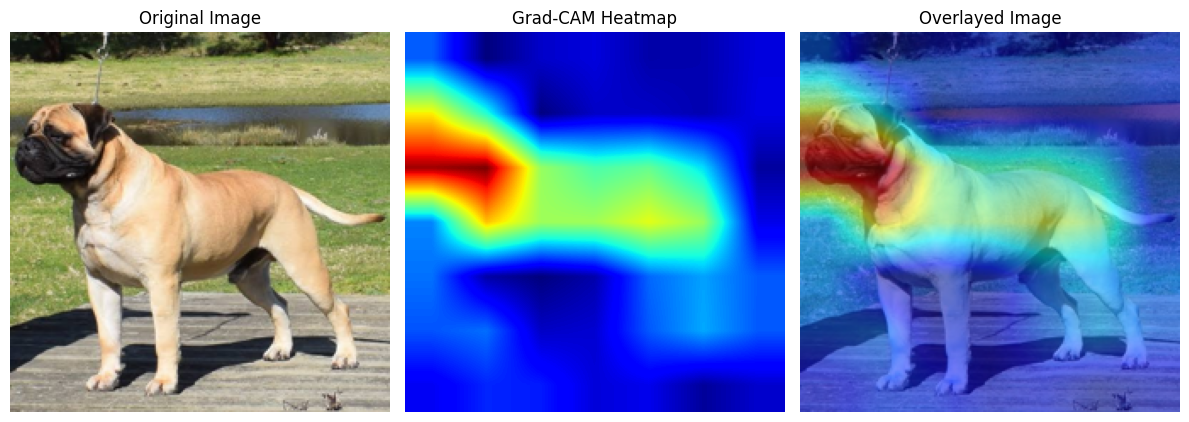

In [7]:
# Load and preprocess an example image (here, 'bull_mastiff.jpg' is an example image file)
input_image = Image.open("/content/bull_mastiff.jpg").resize((224, 224))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

# Get features and gradients
features, gradients = get_features_gradients(model, input_tensor)

# Generate Grad-CAM heatmap
image_shape = (input_image.height, input_image.width)
heatmap = generate_grad_cam(features, gradients, image_shape)

# Visualize the heatmap
visualize_heatmap(input_image, heatmap)